In [1]:
import os 
import sys

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import toast

In [2]:
import scipy.signal as si

In [3]:
import pysm3
import pysm3.units as usm

In [4]:
import skytools

In [5]:
import astropy.units as u 
import astropy as astro

In [6]:
from pixell import enmap, enplot, reproject, utils, curvedsky 
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm

In [7]:
env = toast.utils.Environment.get()
comm, procs, rank = toast.get_world()
nthread = os.environ["OMP_NUM_THREADS"]

In [8]:
mem = toast.utils.memreport(msg="(whole node)", comm=comm, silent=False)

Memory usage (whole node)
       total :  503.138 GB
   available :  260.887 GB
     percent :   48.100 % 
        used :  207.363 GB
        free :  241.441 GB
      active :   16.510 GB
    inactive :  160.328 GB
     buffers :   55.848 MB
      cached :   54.280 GB
      shared :    3.904 GB
        slab :   40.399 GB



In [9]:
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

Scale-invariant power spectrum

In [10]:
def D_ell(maps, lmax, use_pixel_weights=False):
    l_arr = np.arange(0,lmax+1)
    cl_s = hp.anafast(maps, lmax=lmax,use_pixel_weights=use_pixel_weights)
    return (cl_s[:]*l_arr*(l_arr+1)/(2*np.pi))

0. Read map

In [11]:
NSIDE = 512
lmax = 2*NSIDE
l_arr = np.arange(0,lmax+1)

In [12]:
resol = hp.nside2resol(nside=NSIDE)
amin2rad = np.pi/(60*180)

resol_amin = resol*amin2rad

print(resol)

0.0019986849764579854


## CAR (plate carrée)

In [13]:
# Set the size of the box in degrees and convert to radians
dec_from, dec_to = np.deg2rad([-40,-10])
ra_from, ra_to = np.deg2rad([-180, 180])
box = [[dec_from,ra_from],[dec_to,ra_to]]

# read in the map, if you are reading in the full map but would 
# like to just read in the I component you can add [0] to the end of the command.


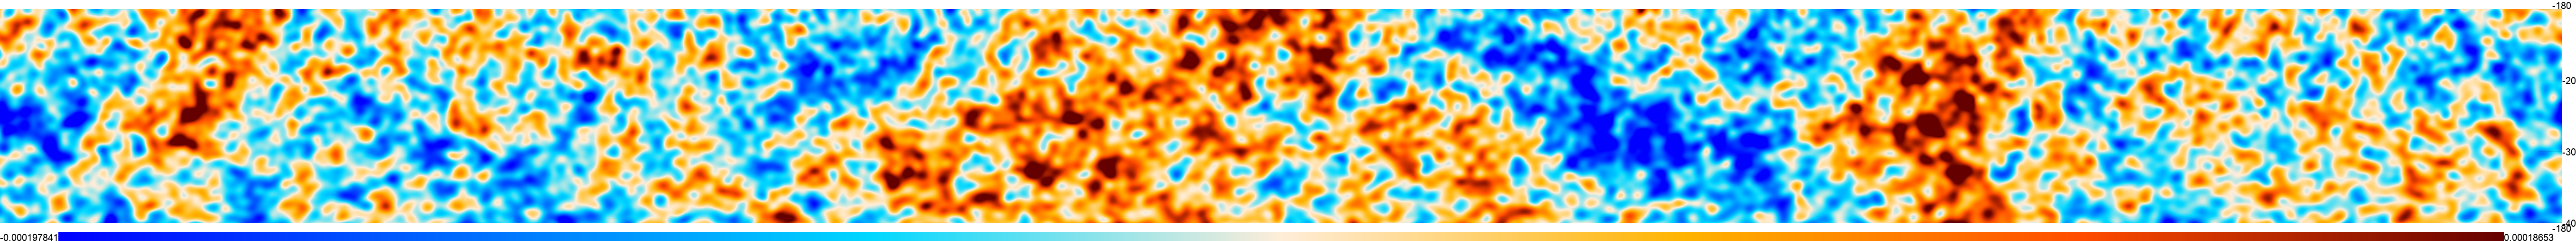

In [14]:
planck_map_car = enmap.read_map('cmb_030_GC_nside_I_car.FITS',box=box)
# Visualize using eshow
eshow(planck_map_car, **{"downgrade": 2, "colorbar":True, "ticks": 10, })

In [15]:
dimensions = planck_map_car.shape

In [16]:
print(dimensions)

(900, 10800)


In [17]:
from toast.qarray import to_iso_angles, rotation, mult, to_lonlat_angles
xrot = rotation([0,1,0], np.pi/2)


In [18]:
from toast.instrument_sim import fake_hexagon_focalplane, plot_focalplane

In [19]:
focalplane = toast.instrument.Focalplane(sample_rate=10*u.Hz#,thinfp=256
                                        )
##One fourth of total detectors in the focalplane
## For S4, sample rate ~10-100

with toast.io.H5File("focalplane_SAT3_SAT_f030.h5", "r", comm=comm, force_serial=True) as f:
            focalplane.load_hdf5(f.handle, comm=comm)

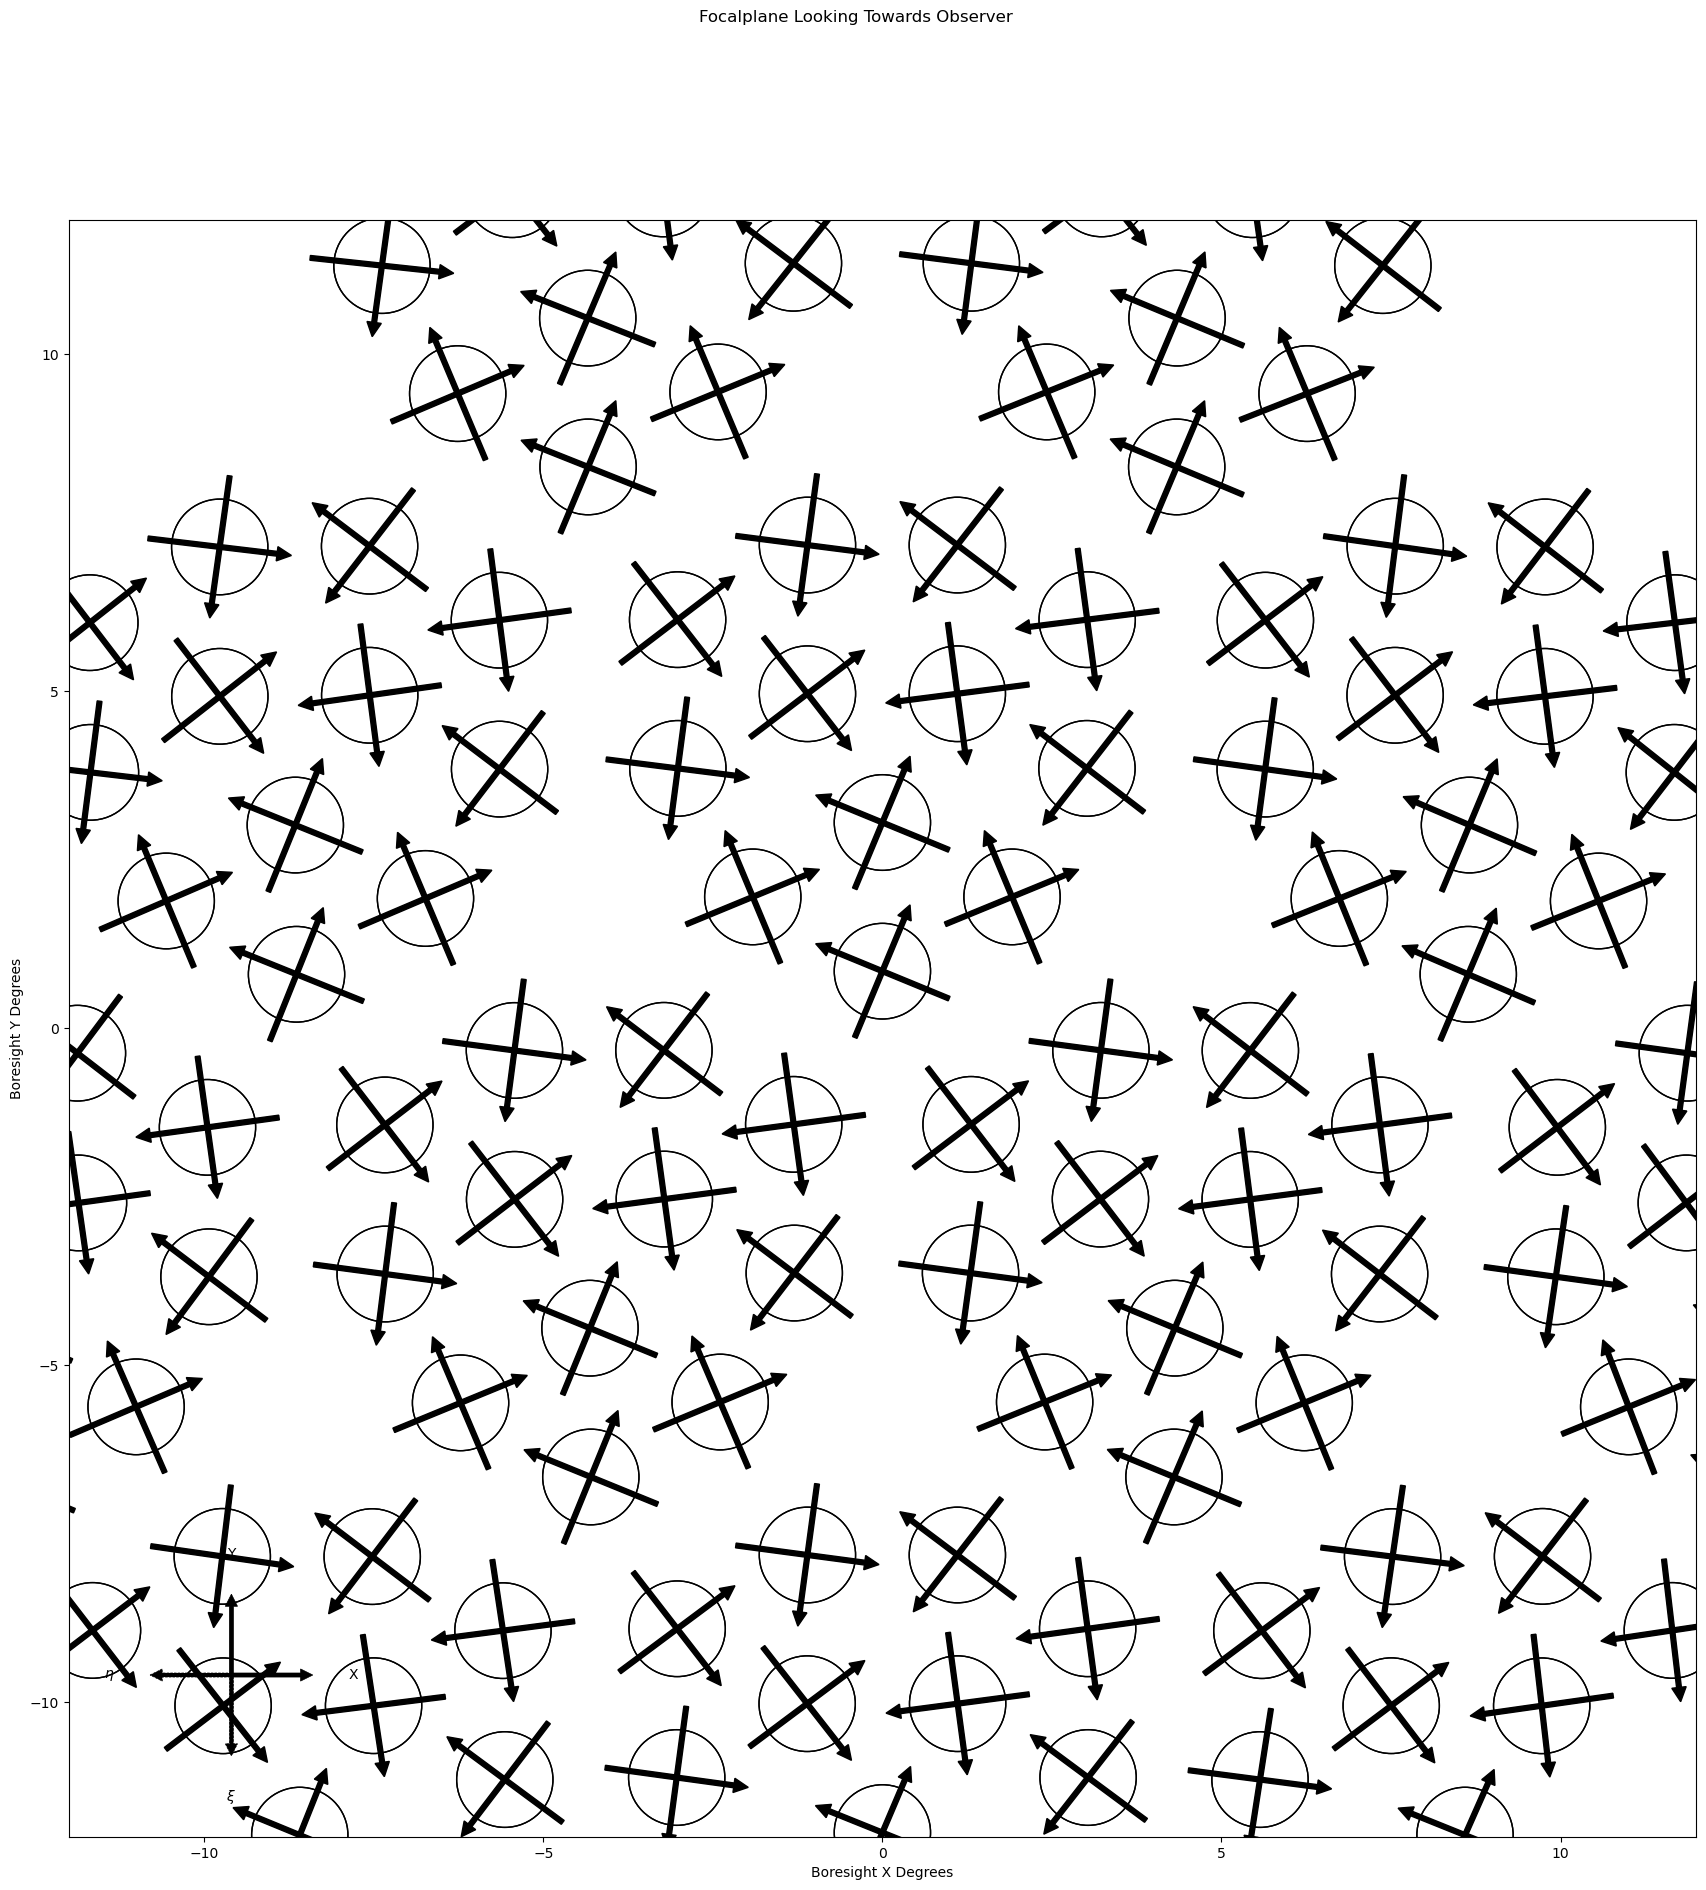

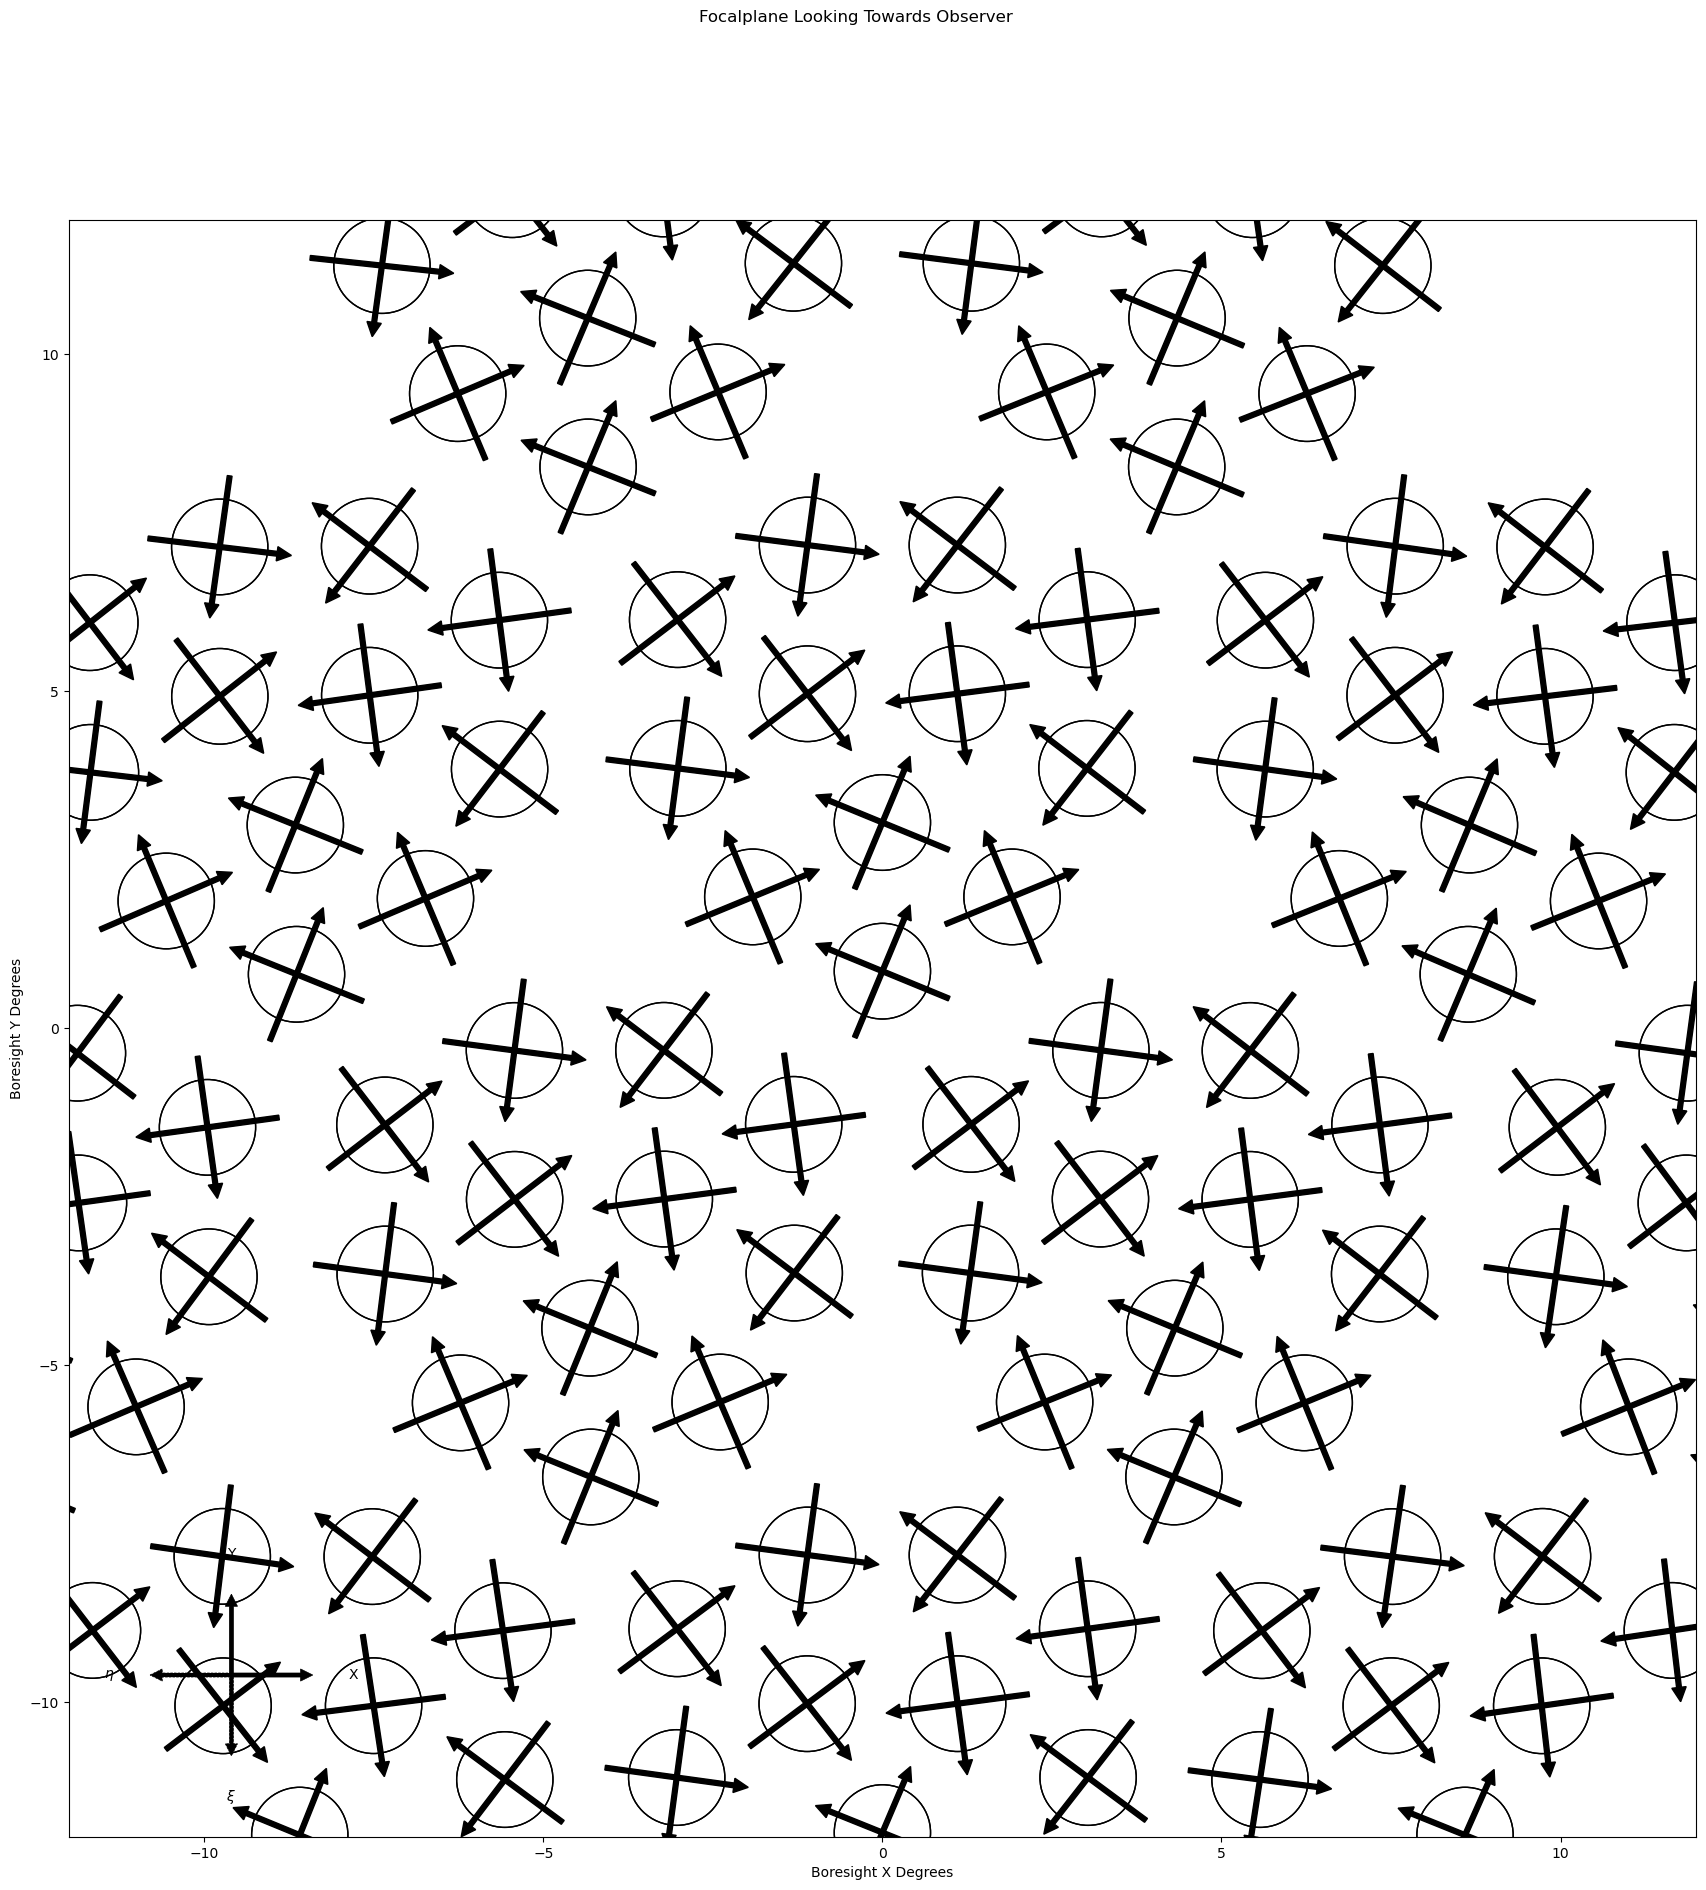

In [20]:
plot_focalplane(focalplane, width=20*u.degree, height = 20*u.degree)

Print focalplane information

In [21]:
iso_angles = np.array([np.degrees(to_iso_angles(mult(xrot,focalplane[detec]["quat"]))) for detec in focalplane.detectors])


In [22]:
focalplane.detector_data[228]

<Row index=228>
       name        pol_leakage psd_fmin psd_fknee psd_alpha  psd_net  bandcenter bandwidth elevation_noise_a elevation_noise_c pwv_noise_a0 pwv_noise_a1 pwv_noise_a2 wafer    ID      pixel      band     fwhm   pol    card  channel  coax  bias   pol_ang_wafer                      quat                         gamma            pol_ang           pol_angle       tube     uid     pol_efficiency
                                  Hz        Hz               K s(1/2)    GHz        GHz                                                                                                                   arcmin                                                                                                                                                                                       
     bytes18         float64   float64   float64   float64   float64   float64    float64       float64           float64        float64      float64      float64    bytes3 int64    bytes11    bytes8  float64 bytes1 bytes2  int64  int64 int64      float64                      float64[4]                     float64           float64            float64       bytes3   int64       float64    
------------------ ----------- -------- --------- --------- --------- ---------- --------- ----------------- ----------------- ------------ ------------ ------------ ------ ------ ----------- -------- ------- ------ ------ ------- ----- ----- ----------------- ----------------------------------------- ----------------- ----------------- ------------------- ------ ---------- --------------
040_000_SAT_f030_A         0.0    1e-05      0.05       1.0 0.0001872      24.75       6.5            0.2062           0.73082     0.965911     0.105767     0.001339    040 400000 ST8-040-000 SAT_f030    85.2      A     40       0     0     0 82.46033391572327 0.10813443372224002 .. 0.9746741755986841 22.28152545694308 22.28152545694308 0.38888598159059057    ST8 2196534689            1.0

Define the schedule, site and telescope

In [23]:
focalplane._det_to_row = {'029_000_SAT_f030_A': 0,
  '029_003_SAT_f030_A': 6}

In [24]:
focalplane.detectors

['029_000_SAT_f030_A', '029_003_SAT_f030_A']

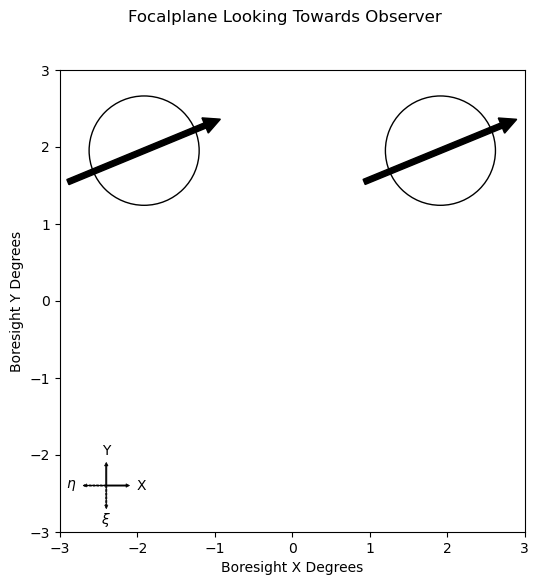

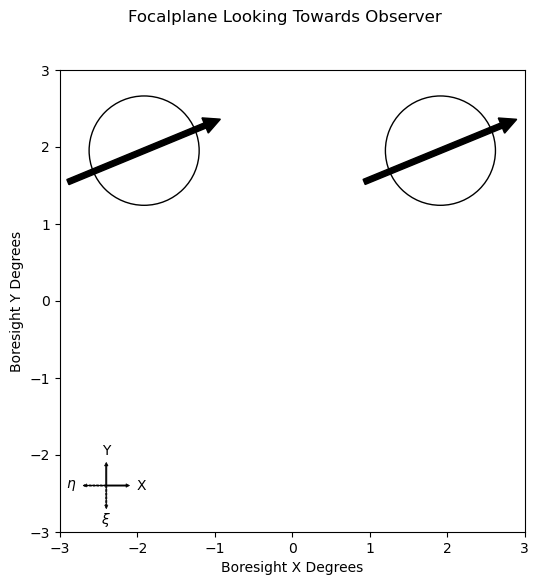

In [25]:
plot_focalplane(focalplane, width=5*u.degree, height = 5*u.degree)

In [26]:
iso_angles[0:7:6]

array([[88.08882932,  1.94993571, 22.5       ],
       [91.91117068,  1.94993571, 22.5       ]])

In [27]:
schedule = toast.schedule.GroundSchedule()
schedule.read("POLE_DEEP_169-DEC0.txt", comm=comm)

TOAST INFO: Loading schedule from POLE_DEEP_169-DEC0.txt
TOAST INFO: Loaded 1 scans from POLE_DEEP_169-DEC0.txt totaling 84.0 minutes.


Print schedule information

In [28]:
schedule

<GroundSchedule site=SOUTH_POLE at -89.991 deg, -44.65 deg, 2843.0 m telescope SAT with 1 scans
  <GroundScan 'POLE_DEEP' at 2027-05-28T06:00:00+00:00 with El = 52.6 deg, Az 63.59 deg -- 134.26 deg>
>

Print telescope information

In [29]:
site = toast.instrument.GroundSite(
        schedule.site_name,
        schedule.site_lat,
        schedule.site_lon,
        schedule.site_alt,
        weather=None,
    )
telescope = toast.instrument.Telescope(
        "My_telescope", focalplane=focalplane, site=site
    )

In [30]:
telescope

<Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = None>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>>

We can have multiple groups for parallel computing (start with one). Create a Data Instance and simulate a ground observation operator.

In [31]:
toast_comm = toast.Comm(world=comm, groupsize=1)

In [32]:
data = toast.Data(comm=toast_comm)

In [33]:
sim_ground = toast.ops.SimGround(name="sim_ground", 
                                 weather="south_pole", 
                                 detset_key="pixel", 
                                 telescope = telescope, 
                                 schedule = schedule
                                ) ##simulate motion of the boresight

In [34]:
sim_ground.apply(data)

1. Create a focalplane with only two detectors in the same row with the same polarization
2. Two timestreams and see where scans overlap (?)
3. Fit a step function and substract it. How to adjust level at the end of overlap?
4. bin 

In [35]:
planck_map_car.shape

(900, 10800)

In [36]:
dimensions = planck_map_car.shape

In [42]:
pointing = toast.ops.PointingDetectorSimple() ##boresight pointing into detector frame (RA/DEC by default)
weights = toast.ops.StokesWeights(detector_pointing = pointing,mode = "I")
#pixels = toast.ops.PixelsHealpix(detector_pointing = pointing, nside = NSIDE)

pixels_wcs = toast.ops.pixels_wcs.PixelsWCS(detector_pointing = pointing,dimensions=dimensions#, resolution=(resol_amin/60*u.degree,resol_amin/60*u.degree)
                                           )

In [50]:
pixels_wcs

<PixelsWCS
  API = 0 # Internal interface version for this operator
  auto_bounds = False # If True, set the bounding box based on boresight and field of view
  bounds = () # The (lon_min, lon_max, lat_min, lat_max) values (Quantities)
  center = (<Quantity 180. deg>, <Quantity 0. deg>) # The center Lon/Lat coordinates (Quantities) of the projection
  center_offset = None # Optional name of shared field with lon, lat offset in degrees
  create_dist = None # Create the submap distribution for all detectors and store in the Data key specified
  detector_pointing = <PointingDetectorSimple
  API = 0 # Internal interface version for this operator
  boresight = boresight_radec # Observation shared key for boresight
  coord_in = None # The input boresight coordinate system ('C', 'E', 'G')
  coord_out = None # The output coordinate system ('C', 'E', 'G')
  det_mask = 1 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  kernel_imple

In [43]:
pointing.apply(data)

In [44]:
#scan_map = toast.ops.ScanHealpixMap(name="scan_healpix_map", file='cmb_030_GC_nside_I.FITS',pixel_pointing = pixels, stokes_weights = weights)
scan_map = toast.ops.ScanWCSMap(name="scan_wcs_map", file = "cmb_030_GC_nside_I_car.FITS",pixel_pointing=pixels_wcs,stokes_weights=weights)


In [45]:
scan_map.save_pointing = True

1. How does it scan? 
1. What is the pixel ordering?
1. What is longitude and latitude

In [46]:
scan_map.apply(data)

In [47]:
data

<Data with 1 Observations:
<Observation
  name = 'POLE_DEEP-169-1'
  uid = '3569251122'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 6, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>>
  session = <Session 'POLE_DEEP-169-1': uid = 527578977, start = 2027-05-28 06:00:00+00:00, end = 2027-05-28 07:23:59.900000+00:00>
  scan_el = 52.6 deg
  scan_min_az = 1.0861993598757675 rad
  scan_max_az = 2.366934565195013 rad
  scan_min_el = 0.9180431865490174 rad
  scan_max_el = 0.9180431865490174 rad
  50400 total samples (50400 local)
  shared:  <SharedDataManager
    times (column): shape=(50400,),

2. Noise simulation

In [48]:
ob = data.obs[0]

In [49]:
ob.detdata['signal']

<DetectorData 2 detectors each with shape (50400,), type float64, units K:
  029_000_SAT_f030_A = [ 0.0 0.0 ... 0.0 0.0 ]
  029_003_SAT_f030_A = [ 0.0 0.0 ... 0.0 0.0 ]
>

In [48]:
ob.detdata.create(name = 'noise',units = u.K)
ob.detdata.create(name = 'total',units = u.K)

In [49]:
noise_model = toast.ops.DefaultNoiseModel()
sim_noise = toast.ops.SimNoise() ###Need to instantiate Noise Model

In [50]:
sim_noise.det_data= 'noise'

In [51]:
noise_model.apply(data) ## Read detector noise from the focalplane
sim_noise.apply(data)

## TOAST destriping

In [52]:
step_0 = 15*u.second


In [53]:
ob

<Observation
  name = 'POLE_DEEP-169-1'
  uid = '3569251122'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 6, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>>
  session = <Session 'POLE_DEEP-169-1': uid = 527578977, start = 2027-05-28 06:00:00+00:00, end = 2027-05-28 07:23:59.900000+00:00>
  scan_el = 52.6 deg
  scan_min_az = 1.0861993598757675 rad
  scan_max_az = 2.366934565195013 rad
  scan_min_el = 0.9180431865490174 rad
  scan_max_el = 0.9180431865490174 rad
  noise_model = <AnalyticNoise model with 2 detectors>
  50400 total samples (50400 local)
  shared:  <SharedDataManager
    tim

In [54]:
time = ob.shared["times"]
n_time = time.shape[0]

In [55]:
ob.detdata['pixels']

<DetectorData 2 detectors each with shape (50400,), type int64, units :
  029_000_SAT_f030_A = [ 8548090 8548090 ... 2683690 2672890 ]
  029_003_SAT_f030_A = [ 8558898 8558898 ... 2683698 2683698 ]
>

In [56]:
ob.detdata['total'][:,:] = ob.detdata['signal'][:,:]+ob.detdata['noise'][:,:]


In [57]:
boresight_radec = ob.shared['boresight_radec']

In [58]:
quats_1 = ob.detdata['quats'][0]
quats_2 = ob.detdata['quats'][1]

In [59]:
iso_ang1 = np.degrees(to_iso_angles(quats_1))
iso_ang2 = np.degrees(to_iso_angles(quats_2))

In [60]:
print(iso_ang1)

[[ 144.61330989  144.61341024  144.61350936 ...  144.50295389
   144.5033651   144.50377601]
 [  -9.26009841   -9.09444024   -8.92878127 ...   79.18705895
    79.02268568   78.85831036]
 [-160.22611626 -160.22538231 -160.22464786 ... -159.91879895
  -159.9189821  -159.91916729]]


In [61]:
th1,phi1,psi1 = iso_ang1
th2,phi2,psi2 = iso_ang2

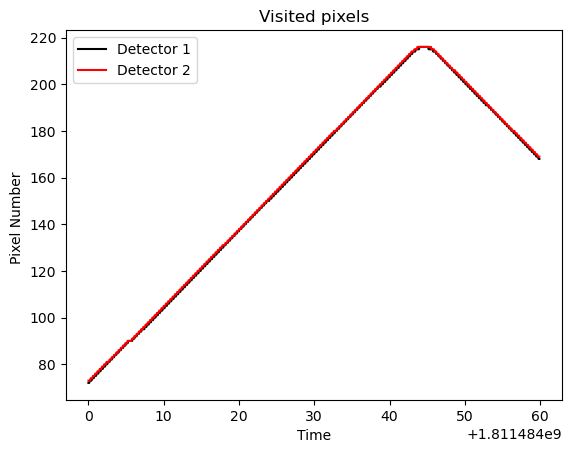

In [62]:
plt.plot(time[:600], (ob.detdata['pixels'][0,:600]%7765200)//10800,'k-',label = 'Detector 1')
plt.plot(time[:600], (ob.detdata['pixels'][1,:600]%7765200)//10800,'r-',label = 'Detector 2')
plt.legend(loc = 'best')
plt.xlabel('Time')
plt.ylabel('Pixel Number ')
plt.title('Visited pixels')
plt.savefig('visited_pipxels.png')

In [63]:
planck_map_car.wcs

car:{cdelt:[0.03333,0.03333],crval:[0,0],crpix:[-5398.62,1200.62]}

In [64]:
hitmap1 = np.zeros(planck_map_car.shape)
hitmap2 = np.zeros(planck_map_car.shape)
for pix in ob.detdata['pixels'][0]:
    hitmap1[pix]+=1
for pix in ob.detdata['pixels'][1]:
    hitmap2[pix]+=1


IndexError: index 8548090 is out of bounds for axis 0 with size 900

In [65]:
#print(ob.detdata['pixels'][0,:10]-8500000)
print(ob.detdata['pixels'][0,50:60])


[8731690 8731690 8731690 8742490 8742490 8742490  977290  977290  977290
  988090]


In [66]:
(8742498-977298)

7765200

In [67]:
58898- 69698

-10800

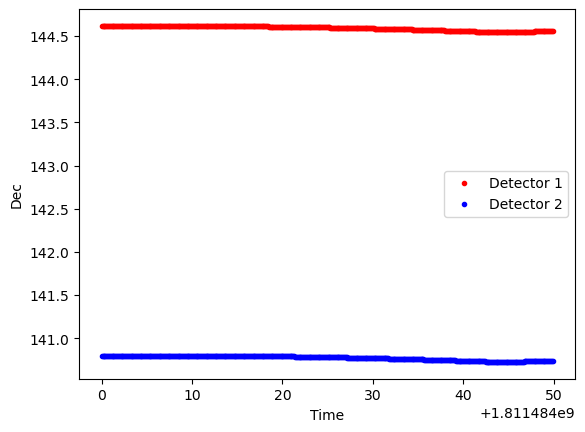

In [68]:
plt.plot(time[0:500], th1[0:500],'r.',label = 'Detector 1')
plt.plot(time[0:500], th2[0:500],'b.',label = 'Detector 2')
plt.xlabel(r'Time')
plt.ylabel('Dec')
plt.legend(loc = 'best')
plt.show()

In [69]:
np.mean(th1[0:50000])

144.5823112130903

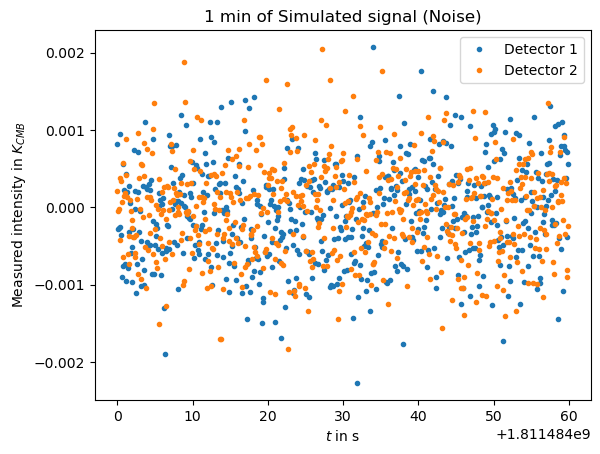

In [70]:
plt.plot(ob.shared["times"][0:600],ob.detdata["noise"][0][0:600],".", label = 'Detector 1') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(ob.shared["times"][0:600],ob.detdata["noise"][1][0:600],".", label = 'Detector 2') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.title('1 min of Simulated signal (Noise)')
plt.legend(loc = 'best')
plt.show()

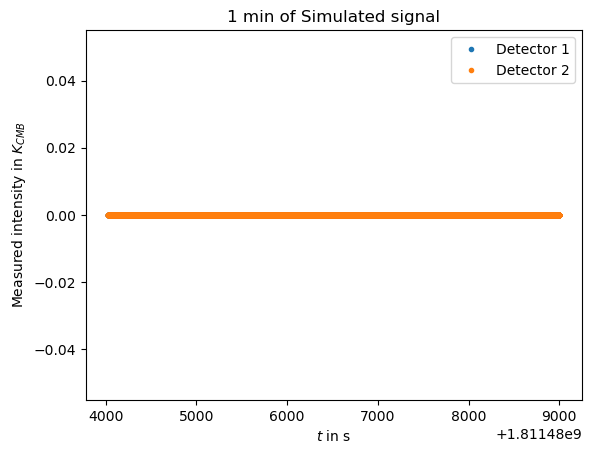

In [73]:
plt.plot(ob.shared["times"][300:50000],ob.detdata["signal"][0][300:50000],".", label = 'Detector 1') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(ob.shared["times"][300:50000],ob.detdata["signal"][1][300:50000],".", label = 'Detector 2') ##Detdata has several data, signal is under "signal", detdata is a 2D array
#plt.ylim(bottom = -1e-4,top = 1e-4)
plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

In [ ]:
throw_lr_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['throw_leftright']])
throw_rl_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['throw_rightleft']])
scan_lr_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['scan_leftright']])
scan_rl_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['scan_rightleft']])

In [ ]:
def interval_slice(arr, interval_list):
    return([arr[interval[0]:interval[1]] for interval in interval_list])

In [ ]:
RA_lr1 =interval_slice(arr = phi1,interval_list=throw_lr_sample)
RA_lr2 =interval_slice(arr = phi2,interval_list=throw_lr_sample)
signal_lr1 =interval_slice(arr = ob.detdata["signal"][0],interval_list=throw_lr_sample)
signal_lr2 =interval_slice(arr = ob.detdata["signal"][1],interval_list=throw_lr_sample)


In [ ]:

plt.plot(RA_lr1[12],signal_lr1[12],'b.')
plt.plot(RA_lr2[12],signal_lr2[12],'r.')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('First left-right throw (signal only)')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')

## Destriping

In [ ]:
templates = [toast.templates.Offset(name="baselines", step_time = step_0)]

In [ ]:
templates

In [ ]:
template_matrix = toast.ops.TemplateMatrix(templates=templates)

In [ ]:
pixels_wcs

In [ ]:
binner = toast.ops.BinMap(pixel_pointing = pixels_wcs, stokes_w = weights)
mapmaker = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix)

In [ ]:
scan_map.pixel_dist

In [ ]:
mapmaker.iter_max = 50
mapmaker.convergence = 1.0e-10

In [ ]:
binner.stokes_weights = weights

In [ ]:
ob.detdata["noise"]

In [ ]:
for detdata in ["noise", "signal","total"]:
    binner.det_data=detdata
    mapmaker.binning= binner
    mapmaker.det_data=detdata
    mapmaker.output_dir = 'customdestriping/'+detdata
    mapmaker.apply(data)

In [ ]:
signal_destriping_bin = enmap.read_map(fname='customdestriping/signal/MapMaker_binmap.fits')
noise_destriping_bin = enmap.read_map(fname='customdestriping/noise/MapMaker_binmap.fits')
total_destriping_bin = enmap.read_map(fname='customdestriping/total/MapMaker_binmap.fits')
signal_destriping = enmap.read_map(fname='customdestriping/signal/MapMaker_map.fits')
noise_destriping = enmap.read_map(fname='customdestriping/noise/MapMaker_map.fits')
total_destriping = enmap.read_map(fname='customdestriping/total/MapMaker_map.fits')

In [ ]:
eshow(signal_destriping)

In [ ]:
lon_arr = np.arange(0,10800)
lat_arr = np.arange(0,900)

In [ ]:
np.where(total_destriping!=0)

In [ ]:
plt.plot(lat_arr,total_destriping[0,:,5290]-total_destriping_bin[0,:,5290],'r-')
#plt.plot(lat_arr,total_destriping[0,:,5298],'b-')

In [ ]:
plt.plot(lat_arr,total_destriping[0,:,5290]-total_destriping_bin[0,:,5290],'r-')

plt.plot(RA_lr1[12],signal_lr1[12],'b.')
plt.plot(RA_lr2[12],signal_lr2[12],'r.')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('First left-right throw (signal only)')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')